In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(cowplot)
  library(gridExtra)
  library(data.table)
})

cres_w_grnas = fread("cres_with_grnas.txt")

cres_w_grnas_egene = fread("cres_with_grna_eqtls.txt")

In [2]:
total_cres = unique(cres_w_grnas$grna_target)
cat("Total cres tested =",length(total_cres),"\n")

grna_cres_w_cgenes = unique(cres_w_grnas$grna_target[cres_w_grnas$significant == 1])
cat("Total number CREs with cgenes =",length(grna_cres_w_cgenes),"\n")

target_cgenes = unique(cres_w_grnas$target_gene[cres_w_grnas$significant == 1])
cat("Total number of target-cgene pairs =",length(target_cgenes),"\n")

cgenes = unique(cres_w_grnas$ensembl_id[cres_w_grnas$significant == 1])
cat("Total number of cgenes =",length(cgenes),"\n")

grna_cres_w_egenes = unique(cres_w_grnas_egene$grna_target)
cat("Total number CREs with egenes =",length(grna_cres_w_egenes),"\n")

length(unique(c(grna_cres_w_cgenes,grna_cres_w_egenes)))

target_egenes = unique(cres_w_grnas_egene$target_gene)
cat("Total number of target-egene pairs =",length(target_egenes),"\n")

egenes = unique(cres_w_grnas_egene$ensembl_id)
cat("Total number of egenes =",length(egenes),"\n")

cres_no_target = unique(cres_w_grnas$grna_target[!cres_w_grnas$grna_target %in% c(grna_cres_w_cgenes,grna_cres_w_egenes)])
cat("CREs without target genes =",length(cres_no_target),"\n")

overlapping_cres = grna_cres_w_cgenes[grna_cres_w_cgenes %in% grna_cres_w_egenes]
cat("Total number of overlapping CRES =",length(overlapping_cres),"\n")

overlapping_cres_cgene = unique(cres_w_grnas$target_gene[cres_w_grnas$grna_target %in% overlapping_cres & cres_w_grnas$significant == 1])
cat("Number of target cgenes overlapping CRES =",length(overlapping_cres_cgene),"\n")

overlapping_cres_egene = unique(cres_w_grnas_egene$target_gene[cres_w_grnas_egene$grna_target %in% overlapping_cres])
cat("Number of target egenes overlapping CRES =",length(overlapping_cres_egene),"\n")

overlapping_target_genes = overlapping_cres_cgene[overlapping_cres_cgene %in% overlapping_cres_egene]
cat("Number of overlapping genes =",length(overlapping_target_genes),"\n")

Total cres tested = 882 
Total number CREs with cgenes = 145 
Total number of target-cgene pairs = 180 
Total number of cgenes = 161 
Total number CREs with egenes = 515 


[1] 563

Total number of target-egene pairs = 1300 
Total number of egenes = 931 
CREs without target genes = 319 
Total number of overlapping CRES = 97 
Number of target cgenes overlapping CRES = 122 
Number of target egenes overlapping CRES = 266 
Number of overlapping genes = 69 


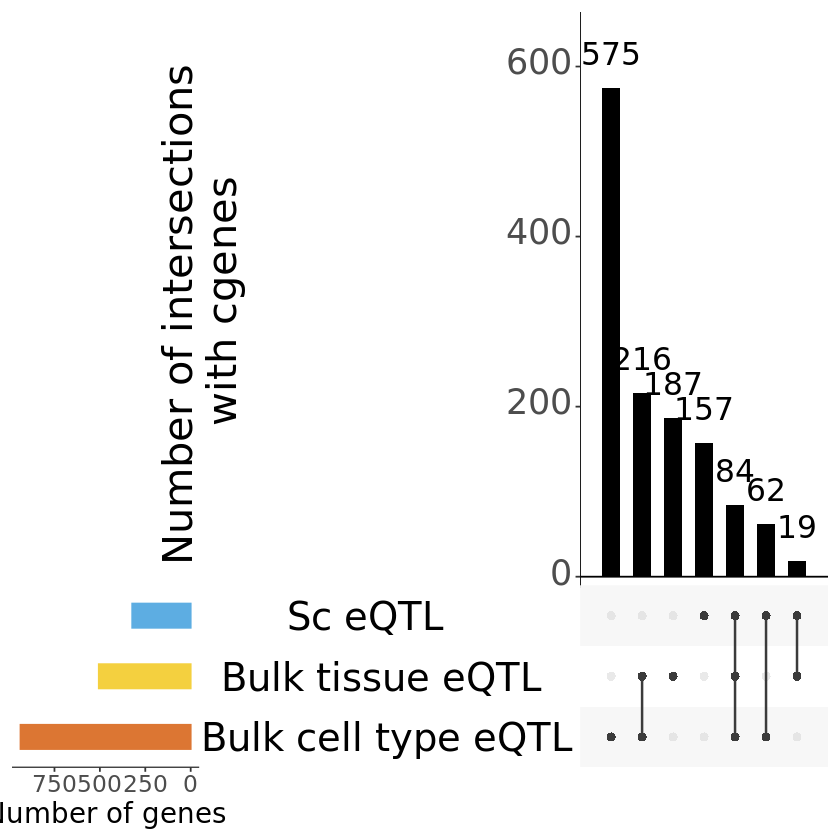

In [3]:
###################
### Upset plot ####
###################
library(UpSetR)

# Define the sc_qtls
sc_qtls <- c("NK_cells", "B_cells", "CD4_T_cells", "CD8_T_cells", "DC_mean", "Mono_cells", "Other_cells", "Other_T_cells")

overlapping_eqtls <- cres_w_grnas_egene

# Step 1: Data Preparation
venn_df <- overlapping_eqtls %>%
  mutate(eqtl = ifelse(eqtl == "GTEx", "blood", eqtl)) %>%
  mutate(group = ifelse(eqtl %in% c("blood", "GTEx"), "Bulk tissue eQTL", 
                        ifelse(eqtl %in% sc_qtls, "Sc eQTL", "Bulk cell type eQTL")),
         group = factor(group, levels = unique(group))) %>%
  mutate(uniq_id = paste(group, ensembl_id, grna_target, sep = "_")) %>% 
  distinct(uniq_id, .keep_all = TRUE)  # Remove multiple GWAS per gene and eQTL

# Step 2: Create a binary matrix for the UpSet plot
upset_data <- venn_df %>%
  select(target_gene, group) %>%
  distinct() %>%
  mutate(value = 1) %>%  # Mark presence with a value of 1
  spread(key = group, value = value, fill = 0)  # Create a wide format with binary values

# Convert to a matrix format
upset_matrix <- as.data.frame(upset_data)
upset_matrix <- upset_matrix[, -1]  # Remove target_gene column, as we just need binary columns

#png(filename = "plots/figure_plots/upset_plot.png", width = 10, height = 8, units = "in", res = 300)
#svg(filename = "plots/figure_plots/upset_plot.svg", width = 10, height = 8)
# Step 3: Create the UpSet Plot
upset_plot = upset(upset_matrix, 
      sets = c("Bulk tissue eQTL", "Sc eQTL", "Bulk cell type eQTL"), 
      order.by = "freq", 
      decreasing = T,
      keep.order = FALSE, 
      main.bar.color = "black", 
      sets.bar.color = rev(c("#5DADE2", "#F4D03F",  "#DC7633")),
      text.scale = c(3, 3, 2, 2, 3.3, 3),
      mainbar.y.label = "Number of intersections \n with cgenes",
      sets.x.label = "Number of genes",
      query.legend = "bottom",
    )
upset_plot

#dev.off()

In [4]:
# Plot of number of associated genes per CRE
eqtl_genes = cres_w_grnas_egene %>%
    mutate(eqtl = ifelse(eqtl == "blood", "Twins UK", eqtl)) %>%
    mutate(group = ifelse(eqtl %in% c("Twins UK", "GTEx"), "Bulk tissue eQTL", 
                        ifelse(eqtl %in% sc_qtls, "Sc eQTL", "Bulk cell type eQTL")),
         group = factor(group, levels = unique(group))) %>%
    filter(group != "Bulk cell type eQTL") %>%
    mutate(uniq_id = paste(eqtl, ensembl_id, grna_target, sep = "_")) %>% 
    distinct(uniq_id, .keep_all = TRUE) %>% # Remove multiple GWAS per gene and eQTL
    group_by(eqtl) %>%
    summarise(n_cre_genes=length(unique(target_gene))) %>%
    mutate(prop_power80 = c(0.38,0.46,0.40,0.85,0.31,0.38,0.79),
          effect_size = rep(0.5,7))

tmp = cres_w_grnas[significant == T]

# CRISPRi power
crispr.power = fread("cres_with_grnas_power.txt")

crispr_genes <- data.frame(
  eqtl = "CRISPRi",
  n_cre_genes = length(target_cgenes),
  prop_power80 = nrow(crispr.power[power>0.79])/nrow(crispr.power),
  effect_size = 0.5
)

all_genes = rbind(eqtl_genes,crispr_genes) %>% 
    arrange(n_cre_genes) %>% rename(study = eqtl)
all_genes[,c(1,3,2,4)]

study,prop_power80,n_cre_genes,effect_size
<chr>,<dbl>,<int>,<dbl>
Mono_cells,0.3100000,69,0.5
B_cells,0.3800000,73,0.5
CD8_T_cells,0.4000000,88,0.5
NK_cells,0.3800000,90,0.5
CD4_T_cells,0.4600000,154,0.5
CRISPRi,0.6119632,180,0.5
Twins UK,0.7900000,309,0.5
GTEx,0.8500000,319,0.5


Warning message in left_join(., hic, "InteractorID"):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 3 of `x` matches multiple rows in `y`.
ℹ Row 2165 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning.”


[1] 180

     [,1] [,2]
[1,]   42  138
[2,]  143 1157


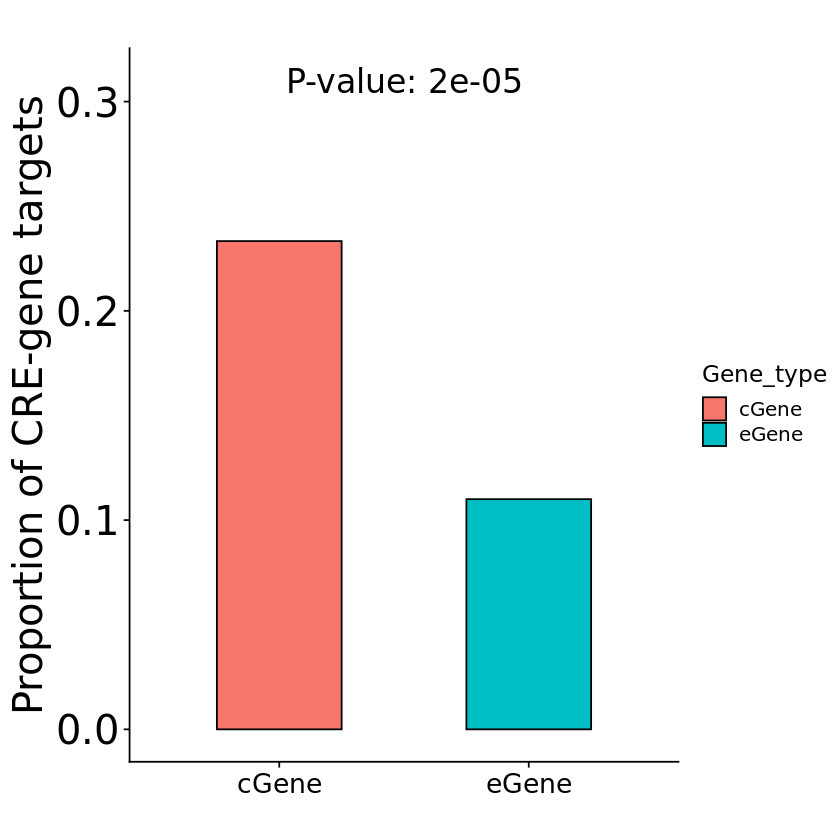

In [5]:
##############################
#### Compare HiC targets #####
##############################
hic = fread("Hi_C/K562/K562.hg19.AllInteractions.SP4.FDR0.1.txt")

intersect = fread("Hi_C/K562/cres_w_grnas_HiC_interactions.bed") %>%
  left_join(hic, "InteractorID")

# Load intersected Hi-c and grnas
cgene_hic = cres_w_grnas %>%
  filter(significant ==1) %>%
  left_join(intersect,"grna_target", relationship = "many-to-many") %>%
  filter(is.na(InteractorID)==F)

# Load intersected Hi-c and grnas
egene_hic = cres_w_grnas_egene %>%
  left_join(intersect,"grna_target", relationship = "many-to-many") %>%
  filter(is.na(InteractorID)==F)

# Fisher exact test
#                       cgene                      egene
# HiCoverlap              a                          b
# HiC non-overlap         c                          d

overlaping_cgenes = length(unique(cgene_hic$target_gene[cgene_hic$gene_name == cgene_hic$RefSeqName]))
overlaping_egenes = length(unique(egene_hic$target_gene[egene_hic$gene_name == egene_hic$RefSeqName]))
total_cgene_targets = length(unique(cres_w_grnas$target_gene[cres_w_grnas$significant == 1]))
total_egene_targets = length(unique(cres_w_grnas_egene$target_gene))

total_cgene_targets

a = overlaping_cgenes
b = overlaping_egenes
c = total_cgene_targets-overlaping_cgenes
d = total_egene_targets-overlaping_egenes

print(matrix(c(a,b,c,d),nrow=2,ncol=2))
test = fisher.test(matrix(c(a,b,c,d),nrow=2,ncol=2))

# Proportion of genes with pLI > 0.9
data <- data.frame(
  Gene_type = factor(c("cGene","eGene"), levels = c("cGene","eGene")),
  Proportion = c(overlaping_cgenes/total_cgene_targets,overlaping_egenes/total_egene_targets))

# Generate a bar plot for gene distances
#png("plots/HiC_barplots.png", width = 6, height = 8,units = "in", res = 300)

ggplot(data, aes(x = Gene_type, y = Proportion, fill = Gene_type)) +
  geom_bar(stat = "identity", color = "black", width = 0.5, position = position_dodge(width = 0.7)) +
  theme_minimal() +
  labs(title = "", x = "", y = "Proportion of CRE-gene targets") +
  annotate("text", x = 1.5, y = 0.31, label = paste0("P-value: ", round(test$p.value, 5)), size = 7, hjust = 0.5) +
  theme_cowplot() +
  theme(
    axis.title.x = element_text(size = 16),
    axis.title.y = element_text(size = 24),
    axis.text.x = element_text(size = 16),
    axis.text.y = element_text(size = 24)
  )

#dev.off()

In [77]:
# CRISPRi power
crispr.power = fread("cres_with_grnas_power.txt")
head(crispr.power)
nrow(crispr.power[power>0.79])/nrow(crispr.power)

logfc,pvalue,significant,ensembl_id,gene_name,tss_distance,finemap_snp_intersect_grna,sentinel_snp,gwas,data,⋯,gene,cre_pert.y,effect_size,sig,nonsig,power,chr,grna_target,grna_pos,target_gene
<dbl>,<dbl>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<dbl>,<int>,<int>,<dbl>,<int>,<chr>,<int>,<chr>
-0.48670908,0.2972066,0,ENSG00000183598,HIST2H3D,759404,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000183598,SNP-19,0.5,3,7,0.3,1,1:150544640,150544640,1:150544640_HIST2H3D
-0.29981633,0.4443334,0,ENSG00000143390,RFX5,-775087,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000143390,SNP-19,0.5,4,6,0.4,1,1:150544640,150544640,1:150544640_RFX5
0.10959875,0.4690311,0,ENSG00000143379,SETDB1,-354175,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000143379,SNP-19,0.5,6,4,0.6,1,1:150544640,150544640,1:150544640_SETDB1
0.18441922,0.5607593,0,ENSG00000143458,GABPB2,-498440,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000143458,SNP-19,0.5,5,5,0.5,1,1:150544640,150544640,1:150544640_GABPB2
0.09231807,0.6224866,0,ENSG00000143393,PI4KB,-755551,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000143393,SNP-19,0.5,5,5,0.5,1,1:150544640,150544640,1:150544640_PI4KB
-0.07762350,0.6796574,0,ENSG00000117360,PRPF3,250715,1:150544640:T:C,1:150544093:C:T,30000,stingseq,⋯,ENSG00000117360,SNP-19,0.5,8,2,0.8,1,1:150544640,150544640,1:150544640_PRPF3


[1] 0.4668328